# Time to generate SCS data

3/2/21

To use cvxpylayers on the Signal Decompositon problem, it is necessary to solve the problem with SCS, complying with DPP rules. The tricky part is in the index selection for the global known set constraint. This can be encoded as a problem parameter, which would allow updating of the selection of holdout indices for SGD, but doing so causes a significant slow-down in generating the SCS problem data. This notebook shows this effect. 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.optimize import minimize_scalar, minimize
from scipy import sparse as sp
from time import time
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('notebook')
import cvxpy as cvx

In [12]:
def make_problem(data, use_ixs, use_parameter=False, use_sparse=True):
    y = data
    n = len(y)
    # Variables
    x1 = cvx.Variable(n)
    x2 = cvx.Variable(n)
    x3 = cvx.Variable(n)
    # Parameters
    theta1 = cvx.Parameter(nonneg=True, value=1)
    theta2 = cvx.Parameter(nonneg=True, value=1e7)  # BIG!!
    theta3 = cvx.Parameter(nonneg=True, value=1e1)
    Mval = np.eye(n)
    Mval = Mval[use_ixs]
    if use_sparse:
        # Setting the pararmeter value with a sparse matrix, as suggested here: 
        # https://github.com/cvxgrp/cvxpy/issues/1159
        Mval = sp.coo_matrix(Mval)
        Mnnz = cvx.Parameter(Mval.nnz, nonneg=True)
        data = np.ones(Mnnz.size)
        rows = Mval.row * n + Mval.col
        cols = np.arange(Mnnz.size)
        m = np.sum(use_ixs)
        Indexer = sp.coo_matrix(
            (data, (rows, cols)), shape=(m * n, Mnnz.size))
        M = cvx.reshape(Indexer @ Mnnz, (m, n), order='C')
        Mnnz.value = Mval.data
    else:
        M = cvx.Parameter(Mval.shape, nonneg=True, value=Mval)
    # Costs
    phi1 = theta1 * cvx.sum_squares(x1)
    phi2 = theta2 * cvx.sum_squares(cvx.diff(x2, k=2))
    phi3 = theta3 * cvx.sum(cvx.abs(cvx.diff(x3, k=1)))
    # Class constraints
    constraints = [x3 >= -1, x3 <= 1]
    # Global constraint
    if use_parameter:
        constraints.append(M @ y == M @ (x1 + x2 + x3))
    else:
        constraints.append(y[use_ixs] == (x1 + x2 + x3)[use_ixs])
    # constraints.append(y == x1 + x2 + x3)
    # Make problem
    problem = cvx.Problem(cvx.Minimize(phi1 + phi2 + phi3), constraints)
    return problem

In [13]:
Ts = np.arange(100, 1100, 100)
out_table = pd.DataFrame(index=Ts, columns=['dense', 'sparse', 'slice'])
for T in Ts:
    np.random.seed(42)
    t = np.linspace(0, 1000, T)
    signal1 = np.sin(2 * np.pi * t * 1 / (500.))
    signal2 = signal.square(2 * np.pi * t * 1 / (450.))
    y = signal1 + signal2 + 0.25 * np.random.randn(len(signal1))
    use_ixs = np.random.uniform(size=T) >= 0.2
    if T <= 500:
        problem = make_problem(y, use_ixs, use_parameter=True, use_sparse=False)
        ti = time()
        data = problem.get_problem_data(cvx.SCS)[0]
        tf = time()
        out_table.loc[T, 'dense'] = tf - ti
    problem = make_problem(y, use_ixs, use_parameter=True, use_sparse=True)
    ti = time()
    data = problem.get_problem_data(cvx.SCS)[0]
    tf = time()
    out_table.loc[T, 'sparse'] = tf - ti
    problem = make_problem(y, use_ixs, use_parameter=False)
    ti = time()
    data = problem.get_problem_data(cvx.SCS)[0]
    tf = time()
    out_table.loc[T, 'slice'] = tf - ti

(81, 100)
(81, 100)
(152, 200)
(152, 200)
(232, 300)
(232, 300)
(309, 400)
(309, 400)
(398, 500)
(398, 500)
(477, 600)
(477, 600)
(562, 700)
(562, 700)
(633, 800)
(633, 800)
(711, 900)
(711, 900)
(798, 1000)
(798, 1000)


In [14]:
out_table

,dense,sparse,slice
100,1.32494,0.047091,0.020114
200,6.754978,0.20738,0.021525
300,21.240442,0.380961,0.023405
400,46.759686,0.831745,0.02548
500,84.985568,1.672739,0.029347
600,NaN,2.961175,0.029629
700,NaN,4.628932,0.032057
800,NaN,7.386507,0.035476
900,NaN,10.776163,0.036697
1000,NaN,15.851372,0.038261


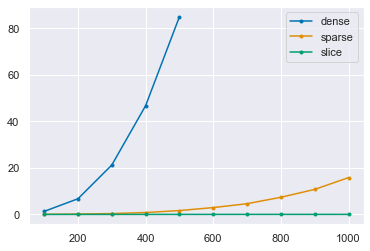

In [16]:
out_table.plot(marker='.');